## Final Project Submission

Please fill out:
* Student name: Marcel Meyer

# Business Case

Situation: I just sold my startup for 3 Million Dollar and want to establish a small incubator.
Talented Data Scientist can live for free at my home and in exchange I get 10 % of their start-ups.
I calculate that I want to keep 2 million dollars for my daily living and as play money (or as old-age provision) and the rest of 1 million I am ready to spend for a house.
For that I need a home in a central area with a lot of bedrooms and a big living room. Pool is a must for excessive pool parties.

I want at least 5 bedrooms - one for me and 4 for the data scientist -, and two bathrooms in the urban area and an above-median living room, so my programmers can code in the living room.
Is the budget enough to buy such a home?



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
import plotly.graph_objects as go
import math

In [95]:
raw_df = pd.read_csv("King_County_House_prices_dataset.csv", parse_dates=[1]) #14 for yr built

raw_df.head(5)
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null datetime64[ns]
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: datetime64[ns](1), float64(8), int64(11), object(1)
memory 

# Datacleaning

In [96]:
# see where we have missing values and how many
raw_df.shape[0] -  raw_df.notna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

According to the column description, waterfront describes whether a house a view to a waterfront or not.
We have three values: NaN, 0 and 1. As a house has a waterfront or not, it is a categorical variable, which can take only two values: yes or no.
Right now we don't know whether 0 or 1 (or even NaN) stand for waterfront view.
As I assume that a waterfront view leads to a higher price, we look for which value has a higher mean price.
We want to include the NaN values and see what they can tell us, so I give them a new categorical value 2.

In [97]:
raw_df["waterfront"] = raw_df["waterfront"].fillna(value=2)
raw_df.groupby("waterfront").price.mean()

waterfront
0.0    5.326420e+05
1.0    1.717215e+06
2.0    5.294301e+05
Name: price, dtype: float64

In [98]:
raw_df.loc[raw_df["waterfront"] == 2,["waterfront"]] = 0

In [99]:
# see why waterfront has so many missing values and understand the columns
print(raw_df["waterfront"].unique())

[0. 1.]


As we can see, the NaN (or new 2) values have almost the same mean price as the 0 values. The 1 value has a much higher mean price, so 1 is probably our value "yes, it has a view to the water".
Now we set all NaN values to 0 as they probably don't have a waterfront view.

We do the same for the column "view"

In [100]:
raw_df["view"] = raw_df["view"].fillna(value=5)

raw_df.groupby("view").price.mean()
print(raw_df.view.unique())


[0. 5. 3. 4. 2. 1.]


The NaN Values seem to be between 0 and 1 according to the house price. So maybe they give us additional information, but as we have only few values, we can't really say.
For now I suppose that the value is 0.

In [101]:
raw_df.loc[raw_df["view"] == 5,["view"]] = 0

Now we don't have any missing values anymore except year_renovated and basement

We have to clean at least the columns

- yr_renovated
- basement

### yr_renovated

fill all NaN values with 0

In [103]:
raw_df.yr_renovated.fillna(0, inplace=True)

In [104]:
raw_df.yr_renovated.astype(int, inplace = True)

0           0
1        1991
2           0
3           0
4           0
5           0
6           0
7           0
8           0
9           0
10          0
11          0
12          0
13          0
14          0
15          0
16          0
17          0
18          0
19          0
20          0
21          0
22          0
23          0
24          0
25          0
26          0
27          0
28          0
29          0
         ... 
21567       0
21568       0
21569       0
21570       0
21571       0
21572       0
21573       0
21574       0
21575       0
21576       0
21577       0
21578       0
21579       0
21580       0
21581       0
21582       0
21583       0
21584       0
21585       0
21586       0
21587       0
21588       0
21589       0
21590       0
21591       0
21592       0
21593       0
21594       0
21595       0
21596       0
Name: yr_renovated, Length: 21597, dtype: int64

### basement
all values with a questionmark can be calculated with the difference of
sqft_living - sqft_above = sqft_basement

After that they will be casted as integers

In [105]:
raw_df.loc[raw_df.sqft_basement == '?', "sqft_basement"] = raw_df.loc[raw_df.sqft_basement == '?', "sqft_living"] - raw_df.loc[raw_df.sqft_basement == '?', "sqft_above"]


In [106]:
raw_df["sqft_basement"] = pd.to_numeric(raw_df.sqft_basement, downcast="integer")

In [107]:
raw_df["zipcode"].unique()

array([98178, 98125, 98028, 98136, 98074, 98053, 98003, 98198, 98146,
       98038, 98007, 98115, 98107, 98126, 98019, 98103, 98002, 98133,
       98040, 98092, 98030, 98119, 98112, 98052, 98027, 98117, 98058,
       98001, 98056, 98166, 98023, 98070, 98148, 98105, 98042, 98008,
       98059, 98122, 98144, 98004, 98005, 98034, 98075, 98116, 98010,
       98118, 98199, 98032, 98045, 98102, 98077, 98108, 98168, 98177,
       98065, 98029, 98006, 98109, 98022, 98033, 98155, 98024, 98011,
       98031, 98106, 98072, 98188, 98014, 98055, 98039])

In [108]:
#raw_df.groupby("zipcode")["price"].mean().sort_values()

In [109]:
raw_df["m2_living"] = raw_df.sqft_living * 0.092903

In [110]:
# see if we have enough data to continue
raw_df[raw_df.bedrooms > 4].describe()


id         price     bedrooms    bathrooms  sqft_living  \
count  1.935000e+03  1.935000e+03  1935.000000  1935.000000   1935.00000   
mean   4.492231e+09  7.978928e+05     5.237726     2.847287   3106.60000   
std    2.832480e+09  6.335040e+05     0.857670     0.908636   1145.80561   
min    1.000102e+06  1.330000e+05     5.000000     1.000000   1120.00000   
25%    2.011400e+09  4.399250e+05     5.000000     2.250000   2350.00000   
50%    4.022901e+09  6.270000e+05     5.000000     2.750000   2890.00000   
75%    7.213000e+09  9.119440e+05     5.000000     3.250000   3600.00000   
max    9.842300e+09  7.700000e+06    33.000000     8.000000  13540.00000   

           sqft_lot       floors   waterfront         view    condition  ...  \
count  1.935000e+03  1935.000000  1935.000000  1935.000000  1935.000000  ...   
mean   1.699320e+04     1.588889     0.011886     0.422739     3.452196  ...   
std    4.174634e+04     0.500884     0.108402     1.011362     0.665025  ...   
min    1.989000e+03     1.000000     0.000000     0.000000     1.000000  ...   
25%    6.219000e+03     1.000000     0.000000     0.000000     3.000000  ...   
50%    8.856000e+03     2.000000     0.000000     0.000000     3.000000  ...   
75%    1.330600e+04     2.000000     0.000000     0.000000     4.000000  ...   
max    1.074218e+06     3.500000     1.000000     4.000000     5.000000  ...   

        sqft_above  sqft_basement     yr_built  yr_renovated       zipcode  \
count  1935.000000    1935.000000  1935.000000   1935.000000   1935.000000   
mean   2437.254264     669.345736  1972.094057     97.024806  98071.988630   
std    1081.169500     632.429609    30.188026    429.506628     53.762422   
min     760.000000       0.000000  1900.000000      0.000000  98001.000000   
25%    1570.000000       0.000000  1958.000000      0.000000  98028.000000   
50%    2240.000000     740.000000  1973.000000      0.000000  98058.000000   
75%    3060.000000    1120.000000  2001.000000      0.000000  98115.000000   
max    9410.000000    4820.000000  2015.000000   2015.000000  98199.000000   

               lat         long  sqft_living15     sqft_lot15    m2_living  
count  1935.000000  1935.000000    1935.000000    1935.000000  1935.000000  
mean     47.576451  -122.208515    2413.978811   13296.442894   288.612460  
std       0.119644     0.121436     813.826440   23386.442352   106.448779  
min      47.177600  -122.507000     460.000000    1099.000000   104.051360  
25%      47.510300  -122.304000    1800.000000    5985.000000   218.322050  
50%      47.587300  -122.215000    2240.000000    8460.000000   268.489670  
75%      47.666850  -122.131000    2910.000000   11808.500000   334.450800  
max      47.777200  -121.718000    6110.000000  311610.000000  1257.906620  

[8 rows x 21 columns]

Now we want to filter according to our conditions:
- at least 5 bedrooms
- two baths
- max 3 million dollars
- living room above median of all houses with at least 5 bedrooms

In [112]:
big_houses = raw_df[(raw_df["bedrooms"] >= 5)
                        & (raw_df.bathrooms >= 2)
                        & (raw_df.price <= 3000000) 
                        ]

In [113]:
big_houses = big_houses[(big_houses.sqft_living > big_houses.sqft_living.median())]


In [114]:
big_houses.drop(labels=["id"], axis = 1, inplace = True)
big_houses.reset_index(drop = True, inplace = True)

In [115]:
#It seems that it will be easier to classify the houses by city rather than by zipcode. Therefore the citynames will be loaded into the DF
# data from https://simplemaps.com/data/us-zips.
urban_zips = [98199,98116,98136,98160,98117,98107,98023,98020,98177,98126,98119,98146,98062,98166,98106,98103,98121,98133,98109,98134,98174,98154,98101,98164,98111,98114,98124,98129,98138,98145,98170,98181,98185,98190,98191,98161,98113,98127,98139,98141,98165,98175,98194,98104,98102,98148,98046,98108,98003,98198,98043,98158,98195,98122,98155,98125,98168,98144,98112,98036,98105,98115,98188,98131,98118,98001,98032,98178,98028,98047,98039,98064,98035,98040,98089,98063,98071,98093,98057,98082,98004,98034,98002,98083,98021,98011,98041,98009,98015,98030,98031,98033,98055,98056,98005,98007,98072,98052,98073]
big_houses = big_houses[big_houses.zipcode.apply(lambda x : x in urban_zips)]


Now we can look at the correlations

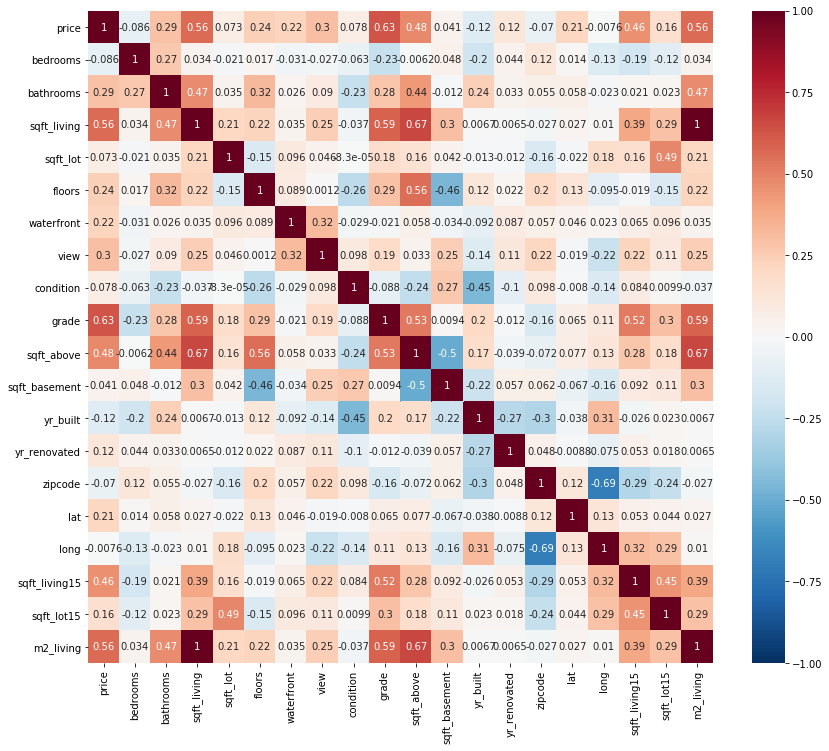

In [116]:
correlation = big_houses.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")

The category "view" is not easy to explain and I don't know what it means. If it doesn't have a big impact, it will be ignored.
Moreover it seems the strongest relation is between m2_living and price, which will be explored in a linear regression.

# Simple linear regression

In [117]:
X = big_houses.m2_living
X = sm.add_constant(X)
y = big_houses.price
# split the variables into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

train_model = sm.OLS(y_train,X_train).fit()
train_result = train_model.summary()
train_result

/Users/marcelmeyer/opt/anaconda3/envs/nf/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     179.2
Date:                Fri, 06 Mar 2020   Prob (F-statistic):           1.37e-33
Time:                        07:35:37   Log-Likelihood:                -5401.6
No. Observations:                 371   AIC:                         1.081e+04
Df Residuals:                     369   BIC:                         1.082e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.668e+05    1.3e+05     -4.346      0.000   -8.23e+05    -3.1e+05
m2_living   4738.7174    353.958     13.388      0.000    4042.689    5434.746
==============================================================================
Omnibus:                       35.617   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.810
Skew:                           0.760   Prob(JB):                     3.07e-10
Kurtosis:                       3.725   Cond. No.                     1.81e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.81e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [118]:
train_model.params

const       -566798.484550
m2_living      4738.717377
dtype: float64

I want at least the sqft_living above the median of 5 rooms and more

In [185]:
my_m2_living = big_houses.m2_living.median()
my_m2_living

341.88304

Let's predict how much this will cost me



In [120]:
my_m2_price = train_model.predict([1,my_m2_living])
round(my_m2_price[0])

1053289.0

In [121]:
train_model.get_prediction([1, my_m2_living]).summary_frame()

mean       mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
0  1.053289e+06  27334.450064  999537.781515   1.107039e+06  47844.367044   

   obs_ci_upper  
0  2.058733e+06

Around 1 Million Dollar +- 40.000 Dollar at a confidence interval of 95% will be the price of a home which fullfills my basic criteria.
As I have some money left, I can see if i can move to a better region.


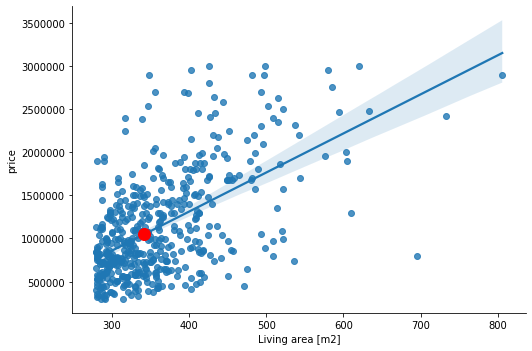

In [122]:
sns.lmplot('m2_living', 'price', data=big_houses, aspect=1.5,)
plt.xlabel("Living area [m2]")
plt.plot(my_m2_living, my_m2_price, 'or', markersize = 12,  )


# Validation of regression

In [123]:

y_pred_1 = train_model.predict(X_test)

print("mean squared error: ", skm.mean_squared_error(y_test, y_pred_1), "and max error: ", skm.max_error(y_test, y_pred_1),
     "and r2-score: ", skm.r2_score(y_test, y_pred_1))
skm.mean_absolute_error(y_test, y_pred_1)

mean squared error:  229445509118.32822 and max error:  1926204.6481405483 and r2-score:  0.27574092257205474


362289.8269034178

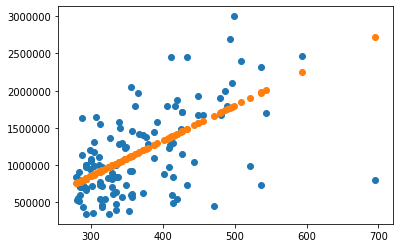

In [124]:
plt.scatter(X_test["m2_living"], y_test)
plt.scatter(X_test["m2_living"], y_pred_1)
plt.show()

In [125]:
trace1 = go.Scatter(
                  x=big_houses["m2_living"],
                  y=big_houses["price"],
                  mode='markers',
                  name='Houses',
                  marker = dict(color="Black")
                  )

trace2 = go.Scatter(
                  x=X_test["m2_living"],
                  y=y_pred_1,
                  mode='lines',
                  name='Fit',
                  marker = dict(color="Red")
                  )
trace3 = go.Scatter(
                    x = [my_m2_living] ,
                    y = my_m2_price ,
                    mode = "markers",
                    name = "Predicted value",
                    marker = dict(size=22, color="Purple" )
    
                   )

layout = go.Layout(
                title='Linear fit of living area to house price',
                plot_bgcolor='Lightgrey', showlegend = True,
                xaxis_title = "Living area [m2]",
                yaxis_title = "Price [$]",
                xaxis=dict(range = [big_houses["m2_living"].min(),big_houses["m2_living"].max()])
                )

data = [trace1, trace2, trace3]
fig = go.Figure(data=data, layout=layout)
print(my_m2_living,my_m2_price)
fig.show()

341.88304 [1053288.61816413]


---
# Find best location

Now that we have a first idea about the price, let's continue with the most important thing: the right place

In [126]:
# list of points of interest

df_poi = pd.DataFrame(data = {"Company": ["University of Washington", "Microsoft", "Amazon", "Starbucks"]
                              , "Lat": [47.655833, 47.650341, 47.622797, 47.588450]
                              , "Long": [-122.300247, -122.132011, -122.339863, -122.336726] })

In [127]:
#adding another company
df_poi.loc[len(df_poi)] = ["Expedia Group", 47.628461, -122.375080]

These

In [521]:
def show_companies (df_map, df_poi = df_poi):
    fig = go.Figure()

    fig.add_trace(go.Scattermapbox(
            lat=df_poi["Lat"],
            lon=df_poi["Long"],
            mode='markers+text',
            marker= dict(size=12,color="red"),
            text = df_poi["Company"],
            textposition="top center",
            hovertext = df_poi["Company"],
            name = "POI")
                 )

    fig.update_layout(
        title = "Points of interest for incubator",
        autosize=True,
        hovermode='closest',
        mapbox_style="open-street-map",
        mapbox=dict(
            bearing=0,
            center=dict(
                lat=47.608013,
                lon=-122.335167
            ),
            
            pitch=0,
            zoom=8
        ),
    )

    fig.show()



In [520]:
show_companies(big_houses,df_poi)

In [130]:
#show_map(raw_df,df_poi)

# Map conclusion
I want the office to be close to the University and top companies, so somewhere above 47.5 latitude and smaller than 122 longitude

In [488]:
city_houses = raw_df[(raw_df["lat"] > 47.5) & (raw_df["long"] < -122) & (raw_df["price"] < 3000000)]


---
find zip codes in rural area with website:
https://www.freemaptools.com/find-zip-codes-inside-user-defined-area.htm

In [489]:
urban_zips = [98199,98116,98136,98160,98117,98107,98023,98020,98177,98126,98119,98146,98062,98166,98106,98103,98121,98133,98109,98134,98174,98154,98101,98164,98111,98114,98124,98129,98138,98145,98170,98181,98185,98190,98191,98161,98113,98127,98139,98141,98165,98175,98194,98104,98102,98148,98046,98108,98003,98198,98043,98158,98195,98122,98155,98125,98168,98144,98112,98036,98105,98115,98188,98131,98118,98001,98032,98178,98028,98047,98039,98064,98035,98040,98089,98063,98071,98093,98057,98082,98004,98034,98002,98083,98021,98011,98041,98009,98015,98030,98031,98033,98055,98056,98005,98007,98072,98052,98073]


Reduce the sample size onto the relevant area

In [490]:
city_houses = city_houses[city_houses.zipcode.apply(lambda x : x in urban_zips)]


It seems that it will be easier to classify the houses by city rather than by zipcode. Therefore the citynames will be loaded into the DF


In [491]:
# data from https://simplemaps.com/data/us-zips.

zipcitycode = pd.read_csv("zips/uszips.csv")

In [492]:
zipcitycode.rename(columns = {"zip": "zipcode"}, inplace = True)

In [493]:
city_houses = city_houses.merge(zipcitycode[["zipcode", "city", "population", "density"]]
                                , on = "zipcode", how = "left")
city_houses.reset_index(drop=True,inplace=True)

Calculate the bedroomsize per house and after that calculate the quantiles.
This should split the houses into houses with smaller and bigger rooms.


In [494]:
bedroomsize = city_houses.m2_living / city_houses.bedrooms
print(bedroomsize.min())
city_houses["bedroomsize"] = bedroomsize
bed_quantile = bedroomsize.quantile([a/5 for a in range(1,6)])
bed_quantile

4.560692727272727


0.2     40.412805
0.4     48.309560
0.6     56.361153
0.8     69.212735
1.0    267.560640
dtype: float64

In [495]:
city_houses.loc[city_houses.bedroomsize < bed_quantile[0.2],"bedroomquantile"] = 1
city_houses.loc[city_houses.bedroomsize.between(bed_quantile[0.2],bed_quantile[0.4]),"bedroomquantile"] = 2
city_houses.loc[city_houses.bedroomsize.between(bed_quantile[0.4],bed_quantile[0.6]),"bedroomquantile"] = 3
city_houses.loc[city_houses.bedroomsize.between(bed_quantile[0.6],bed_quantile[0.8]),"bedroomquantile"] = 4
city_houses.loc[city_houses.bedroomsize.between(bed_quantile[0.8],bed_quantile[1.0]),"bedroomquantile"] = 5

In [496]:
city_houses[["price", "bedroomquantile"]].corr()
quant_med = city_houses.groupby("bedroomquantile", as_index = False)["price"].median()
quant_med = quant_med.rename(columns = {"price":"priceperbedroom"})
quant_med_log = np.log(quant_med["priceperbedroom"])
quant_med


bedroomquantile  priceperbedroom
0              1.0         384000.0
1              2.0         443750.0
2              3.0         510000.0
3              4.0         588000.0
4              5.0         810500.0

In [497]:
city_houses = city_houses.merge(quant_med,how="left")

id       date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520 2014-10-13  221900.0         3       1.00         1180   
1  6414100192 2014-12-09  538000.0         3       2.25         2570   
2  5631500400 2015-02-25  180000.0         2       1.00          770   
3  2487200875 2014-12-09  604000.0         4       3.00         1960   
4  2414600126 2015-04-15  229500.0         3       1.00         1780   

   sqft_lot  floors  waterfront  view  ...  sqft_living15  sqft_lot15  \
0      5650     1.0         0.0   0.0  ...           1340        5650   
1      7242     2.0         0.0   0.0  ...           1690        7639   
2     10000     1.0         0.0   0.0  ...           2720        8062   
3      5000     1.0         0.0   0.0  ...           1360        5000   
4      7470     1.0         0.0   0.0  ...           1780        8113   

   m2_living     city  population  density  bedroomsize  bedroomquantile  \
0  109.62554  Seattle       27280   1919.5    36.541847              1.0   
1  238.76071  Seattle       42475   2653.4    79.586903              5.0   
2   71.53531  Kenmore       22516   1399.0    35.767655              1.0   
3  182.08988  Seattle       16607   2480.6    45.522470              2.0   
4  165.36734  Seattle       28022   2148.4    55.122447              3.0   

   priceperbedroom  m2_pergrade  
0         384000.0    15.660791  
1         810500.0    34.108673  
2         384000.0     8.941914  
3         443750.0    26.012840  
4         510000.0    23.623906  

[5 rows x 29 columns]

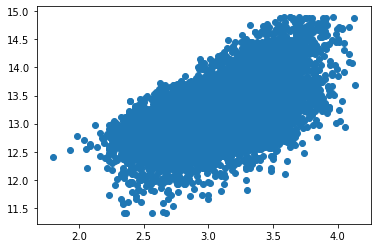

In [498]:
# Creating a new feature by dividing the living through the grade. This shall make different houses in the same area comparabel
plt.scatter(np.log(city_houses.m2_living / (city_houses.grade )), np.log(city_houses.price))
city_houses["m2_pergrade"] = city_houses.m2_living / (14 - city_houses.grade )
city_houses.head(5)

In [499]:
#Calculate the "area" value by grouping the feature before, possibly independent from the condition of the house
zip_price_house = city_houses[["zipcode","m2_pergrade","price"]]
zip_price_house.loc[:,"zip_value_per_m2"] = zip_price_house.price / zip_price_house["m2_pergrade"]
zip_value = zip_price_house.groupby("zipcode" , as_index=False)["zip_value_per_m2"].mean()


/Users/marcelmeyer/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/marcelmeyer/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [500]:

city_houses = city_houses.merge(zip_value , on = "zipcode", how="left")
city_houses[city_houses["zipcode"] == 98007].head(3)

id       date     price  bedrooms  bathrooms  sqft_living  \
5    1736800520 2015-04-03  662500.0         3       2.50         3560   
25   4178300310 2014-07-16  785000.0         4       2.50         2290   
406  4039300400 2014-09-19  469950.0         3       2.25         1620   

     sqft_lot  floors  waterfront  view  ...  sqft_lot15  m2_living      city  \
5        9796     1.0         0.0   0.0  ...        8925  330.73468  Bellevue   
25      13416     2.0         0.0   0.0  ...       13685  212.74787  Bellevue   
406      8701     1.0         0.0   0.0  ...        7910  150.50286  Bellevue   

     population  density  bedroomsize  bedroomquantile  priceperbedroom  \
5         29174   2190.8   110.244893              5.0         810500.0   
25        29174   2190.8    53.186968              3.0         510000.0   
406       29174   2190.8    50.167620              3.0         510000.0   

     m2_pergrade  zip_value_per_m2  
5      55.122447      18811.824892  
25     42.549574      18811.824892  
406    21.500409      18811.824892  

[3 rows x 30 columns]

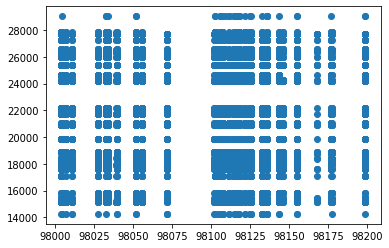

In [501]:
plt.scatter(city_houses.sort_values("zip_value_per_m2")["zipcode"] , city_houses["zip_value_per_m2"])

In [502]:
# trying to see if there is a better relationship if we calculate back.
city_houses["zip_value_grade"] = city_houses["zip_value_per_m2"] * (14 - city_houses["grade"])


zip_value_grade     price
zip_value_grade         1.000000 -0.276777
price                  -0.276777  1.000000

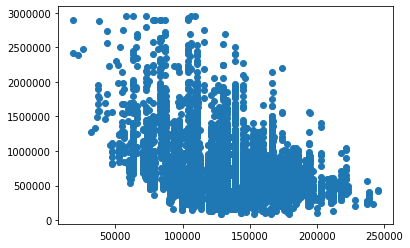

In [503]:
plt.scatter(city_houses.zip_value_grade, city_houses.price)
city_houses[["zip_value_grade", "price"]].corr()

In [504]:
city_houses.loc[:,"quarter"] = city_houses.date.dt.to_period('Q')

In [505]:
#calculate length with basis around center
# -122.25 / 47.63
diff_center = city_houses["lat"] - 47.63
diff_center.name = "diff_center"
city_houses = city_houses.join(diff_center)

In [506]:
city_houses.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'm2_living', 'city',
       'population', 'density', 'bedroomsize', 'bedroomquantile',
       'priceperbedroom', 'm2_pergrade', 'zip_value_per_m2', 'zip_value_grade',
       'quarter', 'diff_center'],
      dtype='object')

In [507]:
city_houses.groupby("quarter")["price"].mean()

quarter
2014Q2    623138.575989
2014Q3    598552.218597
2014Q4    594688.339859
2015Q1    616258.186770
2015Q2    621421.302990
Freq: Q-DEC, Name: price, dtype: float64

In [508]:
city_houses.head()

id       date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520 2014-10-13  221900.0         3       1.00         1180   
1  6414100192 2014-12-09  538000.0         3       2.25         2570   
2  5631500400 2015-02-25  180000.0         2       1.00          770   
3  2487200875 2014-12-09  604000.0         4       3.00         1960   
4  2414600126 2015-04-15  229500.0         3       1.00         1780   

   sqft_lot  floors  waterfront  view  ...  population  density  bedroomsize  \
0      5650     1.0         0.0   0.0  ...       27280   1919.5    36.541847   
1      7242     2.0         0.0   0.0  ...       42475   2653.4    79.586903   
2     10000     1.0         0.0   0.0  ...       22516   1399.0    35.767655   
3      5000     1.0         0.0   0.0  ...       16607   2480.6    45.522470   
4      7470     1.0         0.0   0.0  ...       28022   2148.4    55.122447   

   bedroomquantile  priceperbedroom  m2_pergrade  zip_value_per_m2  \
0              1.0         384000.0    15.660791      15254.505500   
1              5.0         810500.0    34.108673      20881.341693   
2              1.0         384000.0     8.941914      15475.193689   
3              2.0         443750.0    26.012840      24193.465351   
4              3.0         510000.0    23.623906      18434.892101   

   zip_value_grade  quarter  diff_center  
0    106781.538502   2014Q4      -0.1188  
1    146169.391852   2014Q4       0.0910  
2    123801.549509   2015Q1       0.1079  
3    169354.257455   2014Q4      -0.1092  
4    129044.244705   2015Q2      -0.1177  

[5 rows x 33 columns]

In [509]:
# the houses get more expensive by time with the exception of the first quarter 2014

In [510]:
city_houses.yr_built.min()

1900

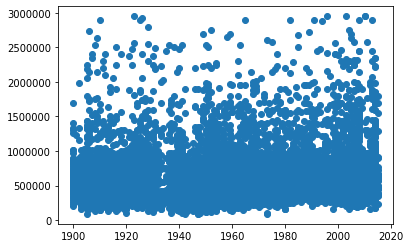

In [511]:
plt.scatter(city_houses.yr_built, city_houses.price)

Maybe years unrenovated are more interesting

# Define the final dataframe

- the most important value we have to define is the m2_living value which should be above average

In [512]:
resulting_for_map = city_houses[city_houses["m2_living"] > my_m2_living]

In [522]:
def show_map_with_hover (df_map, hovervalue, df_poi = df_poi):
    fig = go.Figure()
    fig.add_trace(go.Scattermapbox(
            lat=df_map["lat"],
            lon=df_map["long"],
            mode='markers',
            marker=go.scattermapbox.Marker(
                size=9,
                color = hovervalue,
                colorbar = dict(title="Colorbar", len=0.5),
                colorscale= "Viridis"
            ),
            hovertext = df_map[["m2_living","zip_value_per_m2","zipcode","grade"]]
            , name = "All houses")
                 )
    fig.add_trace(go.Scattermapbox(
        lat=resulting_for_map["lat"],
        lon=resulting_for_map["long"],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=9,
            color = resulting_for_map.zip_value_per_m2
        ),
        hovertext = resulting_for_map[["m2_living","zip_value_per_m2","zipcode","grade"]],
        name = "Potential houses")
             )

    fig.add_trace(go.Scattermapbox(
            lat=df_poi["Lat"],
            lon=df_poi["Long"],
            mode='markers+text',
            marker= dict(size=12,color="red"),
            text = df_poi["Company"],
            textposition="top center",
            hovertext = df_poi["Company"],
            name = "POI")
                 )

    fig.update_layout(
        autosize=True,
        hovermode='closest',
        mapbox_style="open-street-map",
        mapbox=dict(
            bearing=0,
            center=dict(
                lat=47.608013,
                lon=-122.335167
            ),
            pitch=0,
            zoom=8
        ),
    )

    fig.show()




In [523]:
# map with price/sqft_living
show_map_with_hover(city_houses,city_houses.zip_value_per_m2)

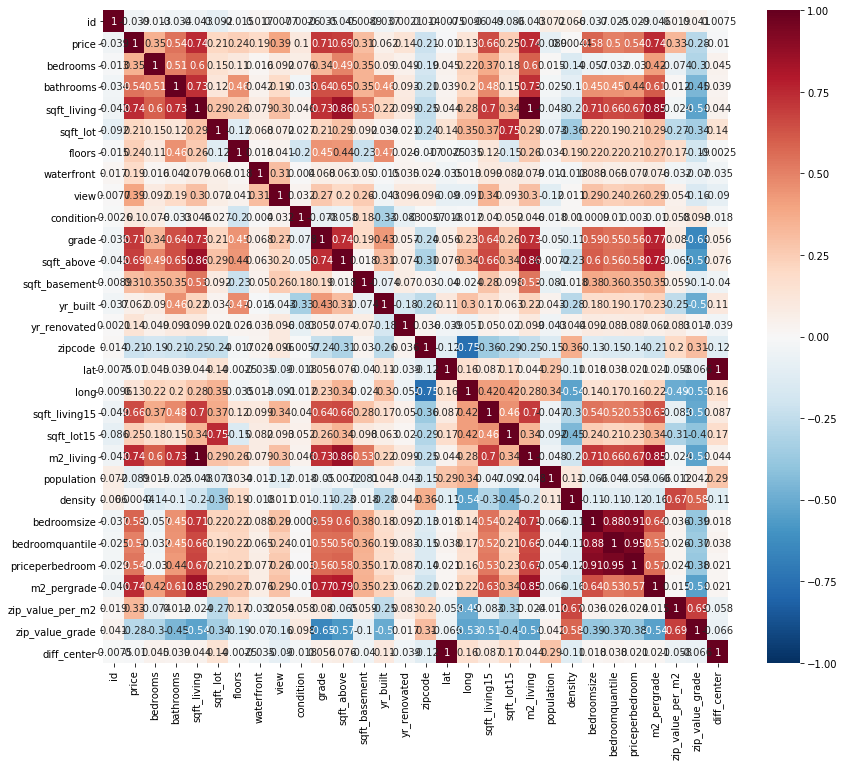

In [478]:
plt.figure(figsize=(14, 12))
sns.heatmap(city_houses.corr(), annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")

# Multilineare Regression

At first we define some functions, so we can play around later with the features
    
    

In [479]:
def x_values(data, discret = [],categorical = []):
    X_discret = data[discret]
    dummies = data[[]]
    if len(categorical) > 0:
        for dummie in categorical:
            dummies = dummies.join(pd.get_dummies(data[dummie], drop_first = True))
    X_values = X_discret.join(dummies)
    return X_values
x_values(city_houses, discret = ["sqft_living"], categorical = ["city", "view"]).head(2)

sqft_living  Bothell  Kenmore  Kirkland  Medina  Mercer Island  Redmond  \
0         1180        0        0         0       0              0        0   
1         2570        0        0         0       0              0        0   

   Renton  Seattle  Woodinville  1.0  2.0  3.0  4.0  
0       0        1            0    0    0    0    0  
1       0        1            0    0    0    0    0


## split the variables into training and test set


In [480]:
def multi_variables(data, discret = [], categorical = []):
    X = x_values(data, discret, categorical)
    X = sm.add_constant(X)
    y = data.price

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    train_model = sm.OLS(y_train,X_train).fit()
    train_result = train_model.summary()
    return train_model, train_result , X_test, y_test

In [484]:
train_model, train_result, X_test, y_test = multi_variables(city_houses
                                                            , discret = ["m2_living","zip_value_per_m2"]
                                                            , categorical = [ "grade" ])




/Users/marcelmeyer/opt/anaconda3/envs/nf/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



In [485]:

y_pred = train_model.predict(X_test)

pd.DataFrame(data = [X_test,y_test,y_pred])
print("mean squared error: ", skm.mean_squared_error(y_test, y_pred), "and max error: ", skm.max_error(y_test, y_pred),
     "and r2-score: ", skm.r2_score(y_test, y_pred))
skm.mean_absolute_error(y_test, y_pred)
np.mean(np.abs((y_test - y_pred) / y_test))

mean squared error:  32382269698.24527 and max error:  1636326.997047305 and r2-score:  0.7442864616003965


0.2085007043069312

In [486]:
# calculating the mean squarred error by hand
eva = pd.DataFrame({"true values":y_test, "predicted": y_pred})
eva["difference"] = eva["true values"] - eva["predicted"]
eva["difference"].abs().mean()

118925.40069569235

### Prediction with log function
The following functions calculate with log model

In [439]:
def x_values_log(data, discret = [],categorical = []):
    X_discret = data[discret]
    for col in discret:
        X_discrt[col] = np.log(X_discrt[col])
    dummies = data[[]]
    if len(categorical) > 0:
        for dummie in categorical:
            dummies = dummies.join(pd.get_dummies(data[dummie], drop_first = True))
    X_values = X_discret.join(dummies)
    return X_values

In [440]:
def multi_variables_log(data, discret = [], categorical = []):
    X = x_values(data, discret, categorical)
    X = sm.add_constant(X)
    y = np.log(data.price)

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    train_model = sm.OLS(y_train,X_train).fit()
    train_result = train_model.summary()
    return train_model, train_result , X_test, y_test

In [441]:
train_model_log, train_result_log, X_test_log, y_test_log = multi_variables_log(city_houses
                                                            , discret = ["m2_living", "zip_value_per_m2"]
                                                            , categorical = ["grade"])




/Users/marcelmeyer/opt/anaconda3/envs/nf/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



In [442]:
y_pred_log = train_model_log.predict(X_test_log)


In [443]:
eva = pd.DataFrame({"true values":y_test_log.apply(math.exp), "predicted": y_pred_log.apply(math.exp)})
eva["difference"] = (eva["true values"] - eva["predicted"]) / eva["true values"]
eva["difference"].abs().mean()

0.18663028256685335

### Conclusion about comparison between normal multilinear regression and log multilinear regression

As you can see above, there is no real advantage of using the log-function. For easier handling we will continue without the log-function

## Prediction of house price

Now we can predict our price in the specific area.

Predict our house in the selected area with the selected grade

In [434]:
train_model.summary()
train_model.predict([1,my_m2_living, (30462.412579), 0,0,0,1,0,0,0,0,0])


array([1195526.09038329])

In [377]:
#with the df: zip_value you can select the right value for your area

In [435]:
train_model.get_prediction([1,my_m2_living, (30462.412579), 0,0,0,1,0,0,0,0,0]).summary_frame()

mean      mean_se  mean_ci_lower  mean_ci_upper   obs_ci_lower  \
0  1.195526e+06  8063.276721   1.179720e+06   1.211332e+06  842050.459882   

   obs_ci_upper  
0  1.549002e+06

# Conclusion

With above prediction we can see that a house in the right location is slightly above the budget. Still we can find with a few changes in the parameters probably a right house for our incubator.


# Future work

- find better prediction features
- maybe there is a stronger correlation in the zip_value_per_m2 feature if we include the condition and view status
- bring more structure into the notebook